# About log_data_to_sequence

This notebook creates minable sequences from log data given a predetermined translation of log actions to sequence actions.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15
from matplotlib.backends.backend_pdf import PdfPages
import os
import numpy as np
import pandas as pd
import getpass
import datetime
import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None);pd.set_option('display.max_rows', None);pd.set_option('precision', 2)
# FOLDER =  'C:\\Users\\'+getpass.getuser()+'\\Documents\\Personal Content\\Lab_skills_study\\parsed log data'

# Preparing the data
We get all log files per student. They are stored in a dictionary like this:
```python
    log_files_per_sim = {'beers': {student1: [log_file_1.txt,log_file_2.txt], ...
                         'capacitor': {student1: [log_file_1.txt,log_file_2.txt], ...}
```

In [2]:
%aimport utils_read_parsing
log_files_per_sim = {}
for sim in ['beers','capacitor']:
    log_files_per_sim[sim] = get_parsed_log_files_per_student_for_sim(sim)

The file Sarah_beers_log_files_per_student.txt has been unpickled and loaded
The file Sarah_capacitor_log_files_per_student.txt has been unpickled and loaded


# Demo with one student
We are going to create the sequence for 1 student whose timeline visualization we have already visualized.

In [3]:
demo_student = 90447168
filename = find_student_log_file('beers',demo_student)
df = prep_parsing_data(filename) #removes model events, adds pauses with arbitrary threshold of 15s
df.head()

D:\Applications\Anaconda2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,User,Sim,Time,Index,User or Model,Component,Event,Item,Action,Laser toggle,Wavelength,Width,Concentration,Absorbance,Detector location,Ruler location,diff in parsed table,Table,X axis,Y axis,X axis scale,Y axis scale,Notes,Timeshifted,Duration,Family
0,90447168,beers-law-lab,3.06,572,user,sim,toggle laser,laser button,NaN,0.0,780.0,1.00,100.0,NaN,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN,5.54,2.48,Vl
1,90447168,beers-law-lab,5.54,1131,user,sim,dragStarted,cuvetteNode,NaN,1.0,780.0,1.00,100.0,0.96,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN,5.59,0.05,Vc
2,90447168,beers-law-lab,5.59,1136,user,sim,dragged,cuvetteNode,increasing,1.0,780.0,1.00,100.0,0.96,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN,5.66,0.07,Vc
3,90447168,beers-law-lab,5.66,1145,user,sim,dragged,cuvetteNode,increasing,1.0,780.0,1.01,100.0,0.97,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN,5.68,0.02,Vc
4,90447168,beers-law-lab,5.68,1148,user,sim,dragged,cuvetteNode,increasing,1.0,780.0,1.01,100.0,0.97,"{u'y': 2, u'x': 6.3}","{u'y': 3.58, u'x': 3.3}",NaN,{},NaN,NaN,NaN,NaN,NaN,5.72,0.03,Vc


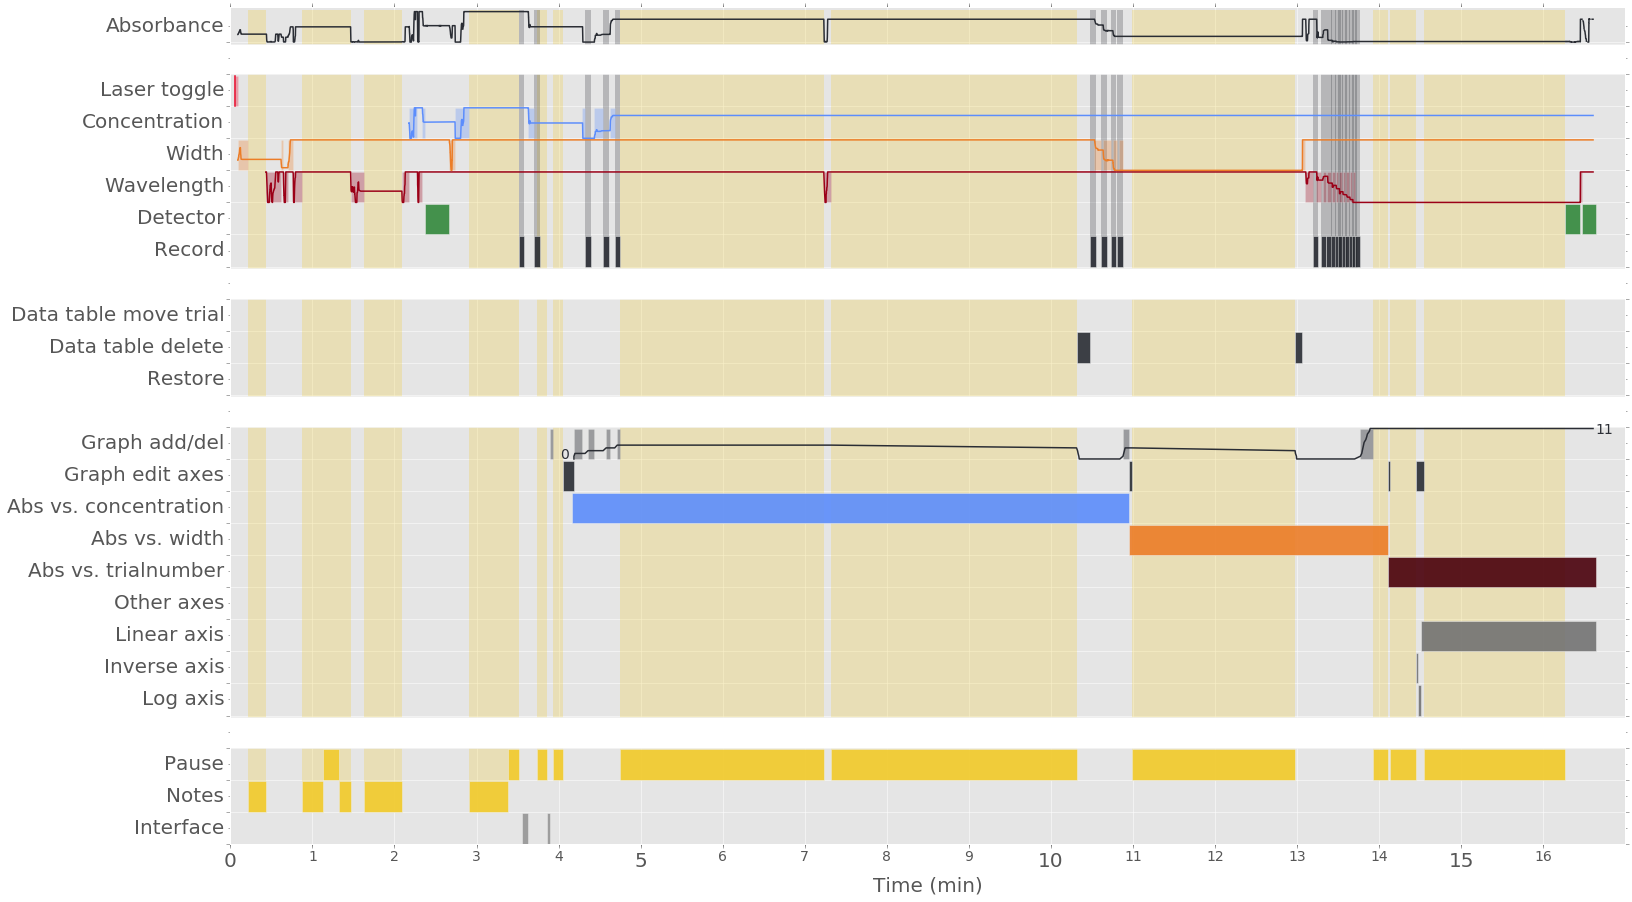

In [4]:
plot(df,to_plot_beers,family_name_to_code,function_to_use,colors)

## One by one, we convert them

In [5]:
rules = pd.read_csv('sequence_parsing_rules.txt', sep='\t')
rules

,Sequence Action,User,Sim,Time,Index,User.1,Component,Event,Item,Action,Laser toggle,Wavelength,Width,Concentration,Absorbance,Detector location,Ruler location,diff in parsed table,Table,X axis,Y axis,X axis scale,Y axis scale,Notes
0,change_concentration,NaN,NaN,NaN,NaN,NaN,NaN,Changed concentration,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,change_concentration,NaN,NaN,NaN,NaN,NaN,NaN,dragEnded,solutionControls,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,change_concentration,NaN,NaN,NaN,NaN,NaN,NaN,dragged,solutionControls,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,change_concentration,NaN,NaN,NaN,NaN,NaN,NaN,dragStarted,solutionControls,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,change_other,NaN,NaN,NaN,NaN,NaN,NaN,dragEnded,detectorNode,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,change_other,NaN,NaN,NaN,NaN,NaN,NaN,dragged,detectorNode,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,change_other,NaN,NaN,NaN,NaN,NaN,NaN,dragStarted,detectorNode,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,change_other,NaN,NaN,NaN,NaN,NaN,NaN,Changed concentration,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,change_other,NaN,NaN,NaN,NaN,NaN,NaN,dragEnded,solutionControls,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,change_other,NaN,NaN,NaN,NaN,NaN,NaN,dragEnded,detectorNode,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def converter(row):
    action = ''
#     print '\nrow'
    for i,rule in rules.iterrows():
        potential_action = rule['Sequence Action']
#         print potential_action
        rule.drop('Sequence Action',inplace=True)
        rule.dropna(inplace=True)
        rule_dict = rule.to_dict()
#         print rule_dict
        match=True
        for column,value in rule_dict.iteritems():
            if row[column]!= value:
                match=False
#                 print column,value, 'no match'
                break
        if match:
#             print 'match!!!'
            return potential_action
    return 'no_match_found'

In [7]:
df['Sequence Action'] = df.apply(converter, axis=1)

In [8]:
from itertools import groupby
sequence = [x[0] for x in groupby(df['Sequence Action'])]
sequence

['laser_on',
 'change_width',
 'pause',
 'change_wavelength',
 'change_width',
 'change_wavelength',
 'change_width',
 'change_wavelength',
 'pause',
 'change_wavelength',
 'pause',
 'change_wavelength',
 'change_concentration',
 'change_wavelength',
 'change_concentration',
 'change_other',
 'change_width',
 'change_concentration',
 'pause',
 'table_add',
 'ignore',
 'change_concentration',
 'table_add',
 'pause',
 'ignore',
 'pause',
 'graph_axis',
 'graph_add',
 'change_concentration',
 'table_add',
 'graph_add',
 'change_concentration',
 'table_add',
 'graph_add',
 'change_concentration',
 'table_add',
 'graph_add',
 'pause',
 'change_wavelength',
 'pause',
 'ignore',
 'table_add',
 'change_width',
 'table_add',
 'change_width',
 'table_add',
 'change_width',
 'table_add',
 'change_width',
 'graph_add',
 'graph_axis',
 'pause',
 'ignore',
 'change_width',
 'change_wavelength',
 'table_add',
 'change_wavelength',
 'table_add',
 'change_wavelength',
 'table_add',
 'change_wavelength'

# Parsing beers for all students

In [9]:
ids = get_students_to_analyze_log()
N = len(ids)

In [10]:
rules = pd.read_csv('sequence_parsing_rules.txt', sep='\t')

In [11]:
all_beers_logs = {}
for student in ids:
    filename = find_student_log_file('beers',student)
    df = prep_parsing_data(filename) #removes model events, adds pauses with arbitrary threshold of 9s
    df = df[df['Event']!='dragged'] #remove drag events, keep dragStart and dragEnded
    print student
    if df.empty:
        continue
    else:
        df['Sequence Action'] = df.apply(converter, axis=1)
        if df[df['Sequence Action']=='no_match_found'].empty:
            pass
        else:
            print df[df['Sequence Action']=='no_match_found']
        all_beers_logs[student] = list(df['Sequence Action'])

11612162
13660166
41947147
64006159
15749160
16901162
51717164
10970160
17114169
17071167
17112137
19416160
11095146
11394167
89047164
13228164
11777163
13654167
86699164
15317162
14805169
10708152
15444164
13140165
15188167
10537160
18174154
12329163
17576140
17168593
13139162
17107166
17448165
19196162
17007153
17018157
19023153
14201151
90447168
15055169
13945160
12665164
15026512
12238164
13134165
12707161
59043165
10232160
24566161
77047160
17655165
17868168
12406161
19018165
18591168
11892169
19913165
83145167
16328144
13726167
46792161
10866146
13981167
18162165
18247165
23836160
10908162
12017165
19618321
85915167
17691169
16752165
13870641
19780165
22340167
11929166
19566168
19608154
17347163
13122150
19053161
16237162
15298166
53262971
16961152
19436162
14828163
17729162
10561164
12907149
19989152
19562150
18922151
16618163
24511163
16233163
14055131
26984162
17597160
18365162
The parsed file has no user events, only model events. No dataframe prepared.
16317166
10192168
1908

In [14]:
# import pickle
# pickle_out = open(os.path.join(BIG_FOLDER,'all_massaged_data\\dict_by_student_beers_parsed_seqs.txt'),"wb")
# pickle.dump(all_beers_logs, pickle_out)
# pickle_out.close()

# Descriptives

In [12]:
nb_use = {}
actions = ['graph_add','graph_axis','graph_remove','graph_scale','table_add']
for a in actions:
    nb_use[a] = []
    for student, seq in all_beers_logs.iteritems():
        nb_use[a].append(seq.count(a))

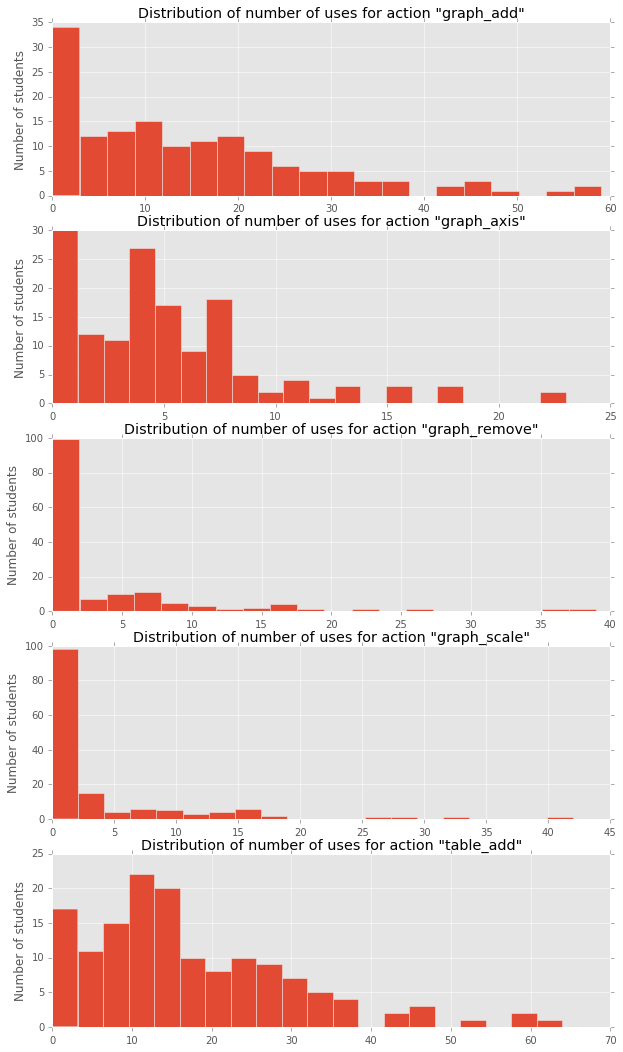

In [13]:
fig,axes = plt.subplots(nrows=len(actions),ncols=1,figsize=(10,18))
for i,a in enumerate(actions):
    ax=axes[i]
    ax.hist(nb_use[a],bins=20)
    ax.set(title='Distribution of number of uses for action "{0}"'.format(a))
    ax.set(ylabel='Number of students')

# to do

* remove 1 student from analysis that we remove in other analyses
* deal with multiple log files
* write rules for caps